In [23]:
import functions
import importlib
from matplotlib import pyplot as plt
import cv2
import numpy as np
importlib.reload(functions)

<module 'functions' from 'c:\\Users\\ivoar\\Documents\\CDIA\\P8\\PDI\\PDI_Projeto_Final\\functions.py'>

In [20]:
imagens, imgs_mask, labels = functions.load_and_resize_images()

Total de imagens: 511
Total de labels: 511


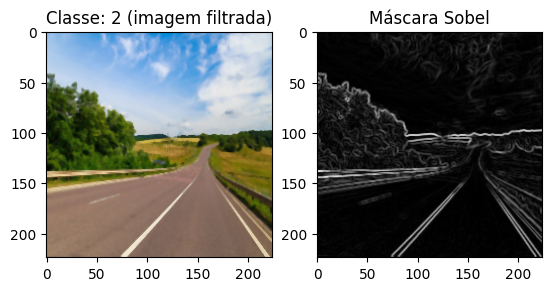

In [56]:
i = 500 # exemplo
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(imagens[i], cv2.COLOR_BGR2RGB))
plt.title(f"Classe: {labels[i]} (imagem filtrada)")

plt.subplot(1,2,2)
plt.imshow(imgs_mask[i].squeeze(), cmap="gray")
plt.title("Máscara Sobel")
plt.show()


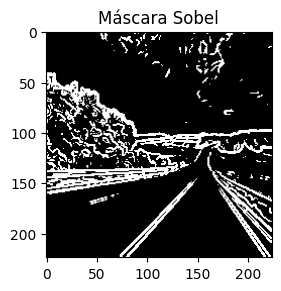

In [57]:
# Defina o limiar (ajuste conforme necessário)
limiar = 30 

# imgs_mask está em escala de cinza (resultado do sobel)
imgs_mask_thresh = []
for mask in imgs_mask:
    _, binary = cv2.threshold(mask, limiar, 255, cv2.THRESH_BINARY)
    imgs_mask_thresh.append(binary)

imgs_mask_thresh = np.array(imgs_mask_thresh)

plt.subplot(1,2,2)
plt.imshow(imgs_mask_thresh[i].squeeze(), cmap="gray")
plt.title("Máscara Sobel")
plt.show()

In [70]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# --- Normalização ---
X_imgs = np.array(imagens) / 255.0
X_masks = np.array(imgs_mask_thresh) / 255.0
X_masks = np.expand_dims(X_masks, axis=-1)

# --- Labels ---
y = np.array(labels)

# --- 1. Undersampling para balancear ---
classes = np.unique(y)
min_count = min([np.sum(y == c) for c in classes])

X_img_bal = []
X_mask_bal = []
y_bal = []

for c in classes:
    idx = np.where(y == c)[0]
    np.random.shuffle(idx)
    idx_cut = idx[:min_count]  # corta para o mínimo
    X_img_bal.append(X_imgs[idx_cut])
    X_mask_bal.append(X_masks[idx_cut])
    y_bal.append(y[idx_cut])

# Concatenar tudo
X_imgs = np.concatenate(X_img_bal, axis=0)
X_masks = np.concatenate(X_mask_bal, axis=0)
y = np.concatenate(y_bal, axis=0)

# --- 2. One-hot após balancear ---
y = to_categorical(y, num_classes=3)

# --- 3. Divisão treino/val/test ---
X_img_train, X_img_test, X_mask_train, X_mask_test, y_train, y_test = train_test_split(
    X_imgs, X_masks, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
)

X_img_train, X_img_val, X_mask_train, X_mask_val, y_train, y_val = train_test_split(
    X_img_train, X_mask_train, y_train, test_size=0.2, random_state=42, stratify=np.argmax(y_train, axis=1)
)

In [71]:
from sklearn.utils.class_weight import compute_class_weight

# calcular pesos
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print("Pesos:", class_weights)


Pesos: {0: np.float64(0.5677777777777778), 1: np.float64(1.0323232323232323), 2: np.float64(3.7028985507246377)}


In [72]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

# Entrada da imagem RGB
input_img = Input(shape=(X_imgs.shape[1], X_imgs.shape[2], 3))

x1 = Conv2D(32, (3,3), activation='relu')(input_img)
x1 = MaxPooling2D((2,2))(x1)
x1 = Conv2D(64, (3,3), activation='relu')(x1)
x1 = MaxPooling2D((2,2))(x1)
x1 = Flatten()(x1)

# Entrada da máscara (1 canal)
input_mask = Input(shape=(X_masks.shape[1], X_masks.shape[2], 1))

x2 = Conv2D(16, (3,3), activation='relu')(input_mask)
x2 = MaxPooling2D((2,2))(x2)
x2 = Conv2D(32, (3,3), activation='relu')(x2)
x2 = MaxPooling2D((2,2))(x2)
x2 = Flatten()(x2)

# Concatenar as duas saídas
merged = Concatenate()([x1, x2])

# Classificação final
dense = Dense(128, activation='relu')(merged)
dense = Dropout(0.5)(dense)
output = Dense(3, activation='softmax')(dense)

# Modelo final
model = Model(inputs=[input_img, input_mask], outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 222, 222,  │        160 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 111, 111,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 109, 109,  │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 54, 54,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 54, 54,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 186624)    │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 93312)     │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 279936)    │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │ 35,831,936 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        387 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,856,515 (136.78 MB)

 Trainable params: 35,856,515 (136.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    [X_img_train, X_mask_train],  # treino
    y_train,
    validation_data=([X_img_val, X_mask_val], y_val),  # validação
    epochs=20,
    batch_size=32
)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 759ms/step - accuracy: 0.9432 - loss: 0.1577 - val_accuracy: 0.9545 - val_loss: 0.1526
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 729ms/step - accuracy: 0.9545 - loss: 0.1210 - val_accuracy: 1.0000 - val_loss: 0.0377
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 739ms/step - accuracy: 1.0000 - loss: 0.0339 - val_accuracy: 0.9545 - val_loss: 0.0741
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 729ms/step - accuracy: 1.0000 - loss: 0.0643 - val_accuracy: 0.9545 - val_loss: 0.0856
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 722ms/step - accuracy: 1.0000 - loss: 0.0412 - val_accuracy: 0.9545 - val_loss: 0.0897
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 741ms/step - accuracy: 0.9886 - loss: 0.0471 - val_accuracy: 0.9545 - val_loss: 0.0782
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step - accuracy: 1.0000 - loss: 0.0164 - val_accuracy: 0.9545 - val_loss: 0.0674
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 767ms/step - accuracy: 1.0000 - loss: 0.0111 - val_accuracy: 0.9545 - val_loss:

In [77]:
loss, acc = model.evaluate([X_img_test, X_mask_test], y_test)
print(f"Test Accuracy: {acc:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9643 - loss: 0.0398
Test Accuracy: 0.96


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


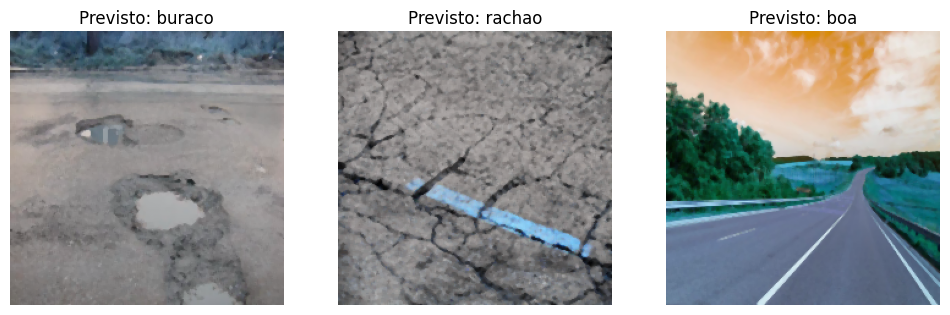

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Classes
class_names = ["buraco", "rachao", "boa"]

# Seleciona uma imagem aleatória de cada classe
indices = []
for c in range(3):
    idxs = np.where(np.argmax(y_test, axis=1) == c)[0]
    idx = np.random.choice(idxs)  # escolha aleatória
    indices.append(idx)

# Loop para plotar
plt.figure(figsize=(12,4))

for i, idx in enumerate(indices):
    img = X_img_test[idx]
    mask = X_mask_test[idx][..., 0]  # pega canal único da máscara

    # Predição do modelo
    pred = model.predict([img[np.newaxis,...], X_mask_test[idx][np.newaxis,...]])
    pred_class = class_names[np.argmax(pred)]

    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.title(f"Previsto: {pred_class}")
    plt.axis('off')

plt.show()
